In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [16]:
# Alterar o nome do papel conforme necessário
ticker_name = "VALE3.SA"

In [24]:
# Carregar os dados do CSV para o histórico de mercado
ticker_history = pd.read_csv(f"./data/{ticker_name}.csv", header=[0, 1], index_col=0)
ticker_history.head()

Price,Close,High,Low,Open,Volume
Ticker,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA
Date,,,,,
2020-01-02,32.831028,32.897498,32.480539,32.619525,17509700
2020-01-03,32.589310,32.933754,32.377809,32.438237,17284800
2020-01-06,32.395931,32.510745,32.117959,32.510745,32787800
2020-01-07,32.631607,32.746421,32.269035,32.329463,16326400
2020-01-08,32.637653,32.855198,32.401981,32.752470,15298500


In [21]:
# Carregar os dados do CSV para histórico de dividendos. A data marcada é equivalente à data EX, ou seja,
# o dia em que a ação sofreu correção em seu valor. Carregar em uma série por ser apenas uma coluna
ticker_dividend = pd.read_csv(f"./data/{ticker_name}_dividend.csv", index_col=0).squeeze()
ticker_dividend.tail()

Date
2023-08-14 00:00:00-03:00    1.918472
2024-03-12 00:00:00-03:00    2.738548
2024-08-05 00:00:00-03:00    2.093798
2024-12-12 00:00:00-03:00    0.520531
2025-03-10 00:00:00-03:00    2.141847
Name: Dividends, dtype: float64

# Encontrar curva de recuperação normalizada
Vamos utilizar algumas data com passadas, normalizar os dados de fechamento com o valor pago do dividendo e descobrir um padrão. Esse padrão vai ser necessário para prever o gráfico futuro após a próxima data com.

`Close_D0` = Primeiro dia de fechamento da série. A normalização será dividir o preço de cada dia por ele.

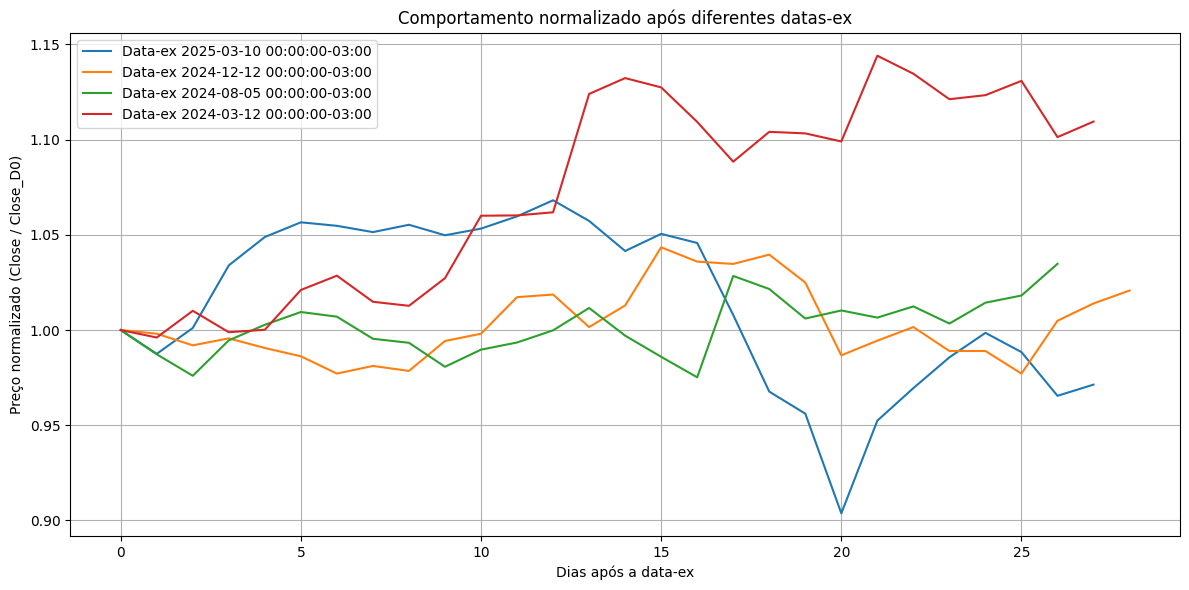

In [82]:
# Juntar dados das últimas data com
total_dates = 5
count_days = 40
curvas_normalizadas = []
df_curves = pd.DataFrame(columns=["Ticker", "Price Normalized"])

for i in range(1, total_dates + 1):
    ex_date = pd.to_datetime(ticker_dividend.index[-i]).replace(tzinfo=None)
    valor_provento = ticker_dividend.iloc[-i]
    
    # Obter histórico de 30 dias após a data-ex
    start_date = ex_date
    end_date = ex_date + pd.Timedelta(days=count_days)
    historico = ticker_history[(pd.to_datetime(ticker_history.index) > start_date) & (pd.to_datetime(ticker_history.index) < end_date)]
    
    # Pula se não tiver dados suficientes. É descontado 15 para ter ao menos 2 semanas de dias úteis
    history_length = len(historico)
    if history_length < count_days - 15:
        continue

    preco_base = historico.iloc[0]["Close"]
    curva_normalizada = historico["Close"].iloc[:count_days] / preco_base
    curva_normalizada.index = range(history_length)  # reinicia índice como dias
    curvas_normalizadas.append(curva_normalizada)

    df_curves = pd.concat([df_curves, curva_normalizada], ignore_index=True)

# Plotar todas as curvas no mesmo gráfico
plt.figure(figsize=(12, 6))
for i, curva in enumerate(curvas_normalizadas):
    plt.plot(curva, label=f"Data-ex {ticker_dividend.index[-(i+1)]}")

plt.title("Comportamento normalizado após diferentes datas-ex")
plt.xlabel("Dias após a data-ex")
plt.ylabel("Preço normalizado (Close / Close_D0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Normalizar a curva final
O código acima encontra todas as curvas das data ex que queremos. Agora, iremos normalizar cada curva em uma única usando **desvio padrão diário**.

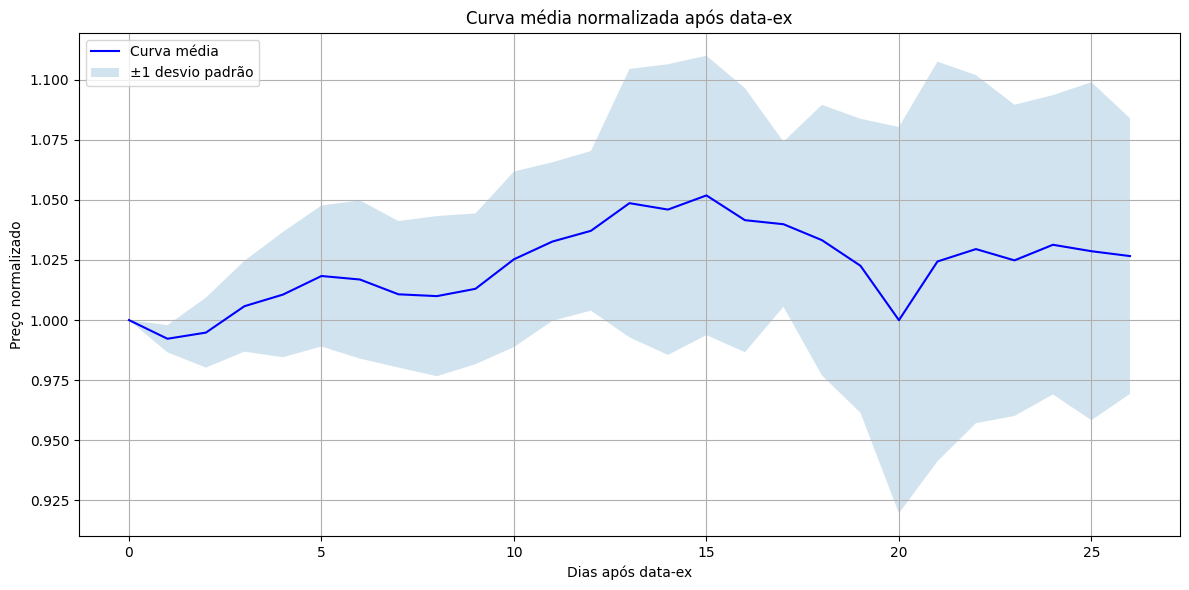

In [83]:
# Juntar todas as curvas em um DataFrame
df_curvas = pd.concat(curvas_normalizadas, axis=1).T
df_curvas = df_curvas.dropna(axis=1)  # remove dias incompletos

# Calcular média e desvio padrão por dia
media = df_curvas.mean()
desvio = df_curvas.std()

plt.figure(figsize=(12, 6))
plt.plot(media, label="Curva média", color="blue")
plt.fill_between(media.index, media - desvio, media + desvio, alpha=0.2, label="±1 desvio padrão")
plt.title("Curva média normalizada após data-ex")
plt.xlabel("Dias após data-ex")
plt.ylabel("Preço normalizado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
# Obter histórico de preços ao redor da data-ex
inicio = last_data_ex - pd.Timedelta(days=10)
fim = last_data_ex + pd.Timedelta(days=15)
ticker_history[(pd.to_datetime(ticker_history.index) > inicio) & (pd.to_datetime(ticker_history.index) < fim)]

Price,Close,High,Low,Open,Volume
Ticker,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA
Date,,,,,
2025-03-05,53.501869,54.108205,53.309381,54.040835,13843400
2025-03-06,54.088955,54.396934,53.463369,53.549989,17678400
2025-03-07,54.878155,55.195757,53.463371,53.877219,25480600
2025-03-10,53.990002,54.549999,53.250000,54.230000,23626600
2025-03-11,54.439999,54.720001,53.410000,54.080002,23060100
2025-03-12,53.759998,54.500000,53.150002,54.500000,18825700
2025-03-13,54.500000,55.160000,53.700001,53.880001,20584600
2025-03-14,56.290001,56.410000,55.160000,55.200001,31789300


In [15]:
# Conferir matriz de correlação entre variáveis independentes
print(vale[['Open', 'High', 'Low', 'Volume']].corr())

Price                Open      High       Low    Volume
Ticker           VALE3.SA  VALE3.SA  VALE3.SA  VALE3.SA
Price  Ticker                                          
Open   VALE3.SA  1.000000  0.998869  0.998884 -0.130650
High   VALE3.SA  0.998869  1.000000  0.998657 -0.116871
Low    VALE3.SA  0.998884  0.998657  1.000000 -0.141556
Volume VALE3.SA -0.130650 -0.116871 -0.141556  1.000000


In [5]:
vale['Label'] = vale['Close'].shift(-1)
vale.dropna(inplace=True)

X = vale[['Open', 'High', 'Low']]
y = vale['Label'].astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

k_values = range(1, 21)
rmse_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))  # Calcular o RMSE
    rmse_scores.append(rmse)

best_k = k_values[np.argmin(rmse_scores)]
print(f"Melhor valor de k: {best_k}")
print(f"RMSE para os diferentes valores de k: {rmse_scores}")

knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_knn_best = knn_best.predict(X_test)

def avaliar(y_test, y_pred, nome_modelo):
    print(f"\n=== {nome_modelo} ===")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
    print("R²:", r2_score(y_test, y_pred))

avaliar(y_test, y_pred_lr, "Regressão Linear")
avaliar(y_test, y_pred_knn_best, "KNN (Melhor k)")

num_amostras = len(y_test)

plt.figure(figsize=(10, 5))
plt.plot(range(num_amostras), y_test.values[:num_amostras], label="Real", marker='o')
plt.plot(range(num_amostras), y_pred_lr[:num_amostras], label="Reg. Linear", marker='x')
plt.plot(range(num_amostras), y_pred_knn_best[:num_amostras], label=f"KNN (k={best_k})", marker='s')
plt.title("Comparação dos modelos (Primeiras amostras)")
plt.xlabel("Amostras")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.grid(True)
plt.show()


TypeError: unsupported operand type(s) for /: 'str' and 'int'